In [1]:
from huggingface_hub import login
import os

login(token=os.getenv("HF_TOKEN"))

#from huggingface_hub import notebook_login
#notebook_login()

In [2]:
from datasets import load_dataset

dataset_id = '2024-mcm-everitt-ryan/job-bias-synthetic-human-benchmark-v2'

dataset = load_dataset(dataset_id)

In [3]:
import json

import pandas as pd

df = pd.concat([
    dataset['train'].to_pandas(),
    dataset['val'].to_pandas(),
    dataset['test'].to_pandas()
])
df = df[df['verified'] == True]
df.head(3)

,id,label_age,analysis_age,label_disability,analysis_disability,label_feminine,analysis_feminine,label_general,analysis_general,label_masculine,...,label_neutral,analysis_neutral,label_racial,analysis_racial,label_sexuality,analysis_sexuality,verified,synthetic,text,metadata
0,Synthetic:meta-llama:Meta-Llama-3-70B-Instruct...,False,,False,,False,,False,,False,...,True,None,False,,False,The sexuality rationale in this job posting is...,True,True,"Company: Barker, Pierce and Banks\nJob Title: ...","{""position"": ""standards specialist"", ""inferenc..."
1,Kaggle::techmap::614a798e287b955e077cff75::mon...,False,None,False,None,False,None,False,None,False,...,True,None,False,None,False,None,True,False,5-7 years of relevant work experience. \nExce...,"{""document_id"": ""Kaggle::techmap::614a798e287b..."
2,Synthetic:meta-llama:Meta-Llama-3-70B-Instruct...,False,,False,,False,,False,,False,...,True,None,False,,False,,True,True,"Data and Technology Analyst at Hall, Johnson a...","{""position"": ""data and technology analyst"", ""i..."


In [4]:
print(f"Column Names: {df.columns}")
print(f"Columns: {len(df.columns)}")
print(f"Rows: {len(df)}")

Column Names: Index(['id', 'label_age', 'analysis_age', 'label_disability',
       'analysis_disability', 'label_feminine', 'analysis_feminine',
       'label_general', 'analysis_general', 'label_masculine',
       'analysis_masculine', 'label_neutral', 'analysis_neutral',
       'label_racial', 'analysis_racial', 'label_sexuality',
       'analysis_sexuality', 'verified', 'synthetic', 'text', 'metadata'],
      dtype='object')
Columns: 21
Rows: 2616


In [5]:
label_columns = [col for col in df.columns if col.startswith('label_')]
analysis_columns = [col for col in df.columns if col.startswith('analysis_')]
categories = [col.replace('label_', '') for col in label_columns]
text_column = 'text'

print(f"Categories: {categories}")
print(f"Labels: {label_columns}")
print(f"Analysis: {analysis_columns}")
print(f"Input: {text_column}")

print(f"\nRows: {len(df)}")
for category in categories:
    label = f"label_{category}"
    bias = len(df[df[label] == True])
    unbiased = len(df[df[label] == False])
    print(f"\t{category}: {bias} biased, {unbiased} unbiased")

non_neutral = df[label_columns].apply(lambda x: any([i for i in x]), axis=1).sum()
neutral = df[label_columns].apply(lambda x: all([not i for i in x]), axis=1).sum()
print(f'\tHas at least one bias category: {non_neutral} ({non_neutral / len(df):.2%})')
print(f'\tHas no bias categories: {neutral} ({neutral / len(df):.2%})')


Categories: ['age', 'disability', 'feminine', 'general', 'masculine', 'neutral', 'racial', 'sexuality']
Labels: ['label_age', 'label_disability', 'label_feminine', 'label_general', 'label_masculine', 'label_neutral', 'label_racial', 'label_sexuality']
Analysis: ['analysis_age', 'analysis_disability', 'analysis_feminine', 'analysis_general', 'analysis_masculine', 'analysis_neutral', 'analysis_racial', 'analysis_sexuality']
Input: text

Rows: 2616
	age: 201 biased, 2415 unbiased
	disability: 203 biased, 2413 unbiased
	feminine: 194 biased, 2422 unbiased
	general: 204 biased, 2412 unbiased
	masculine: 198 biased, 2418 unbiased
	neutral: 1352 biased, 1264 unbiased
	racial: 194 biased, 2422 unbiased
	sexuality: 201 biased, 2415 unbiased
	Has at least one bias category: 2616 (100.00%)
	Has no bias categories: 0 (0.00%)


In [6]:
def set_type(sample):
    if sample['synthetic']:
        md = json.loads(sample['metadata'])
        model = md.get('model').lower()
        for model_type in ['llama-3-70b','gpt-4o']:
            if model_type in model:
                return model_type
    else:
        return 'Real'
    
    return None
    
def set_model(sample):
    if sample['synthetic']:
        md = json.loads(sample['metadata'])
        return md.get('model')
    return None
    
def set_country(sample):
    if not sample['synthetic']:
        md = json.loads(sample['metadata'])
        return md.get('country')
    return None
    
def set_source(sample):
    if not sample['synthetic']:
        md = json.loads(sample['metadata'])
        return md.get('source')
    return None
    

In [7]:
df["model"] = df.apply(set_model, axis=1)
df["type"] = df.apply(set_type, axis=1)
df["country"] = df.apply(set_country, axis=1)
df["source"] = df.apply(set_source, axis=1)
df.head(3)

,id,label_age,analysis_age,label_disability,analysis_disability,label_feminine,analysis_feminine,label_general,analysis_general,label_masculine,...,label_sexuality,analysis_sexuality,verified,synthetic,text,metadata,model,type,country,source
0,Synthetic:meta-llama:Meta-Llama-3-70B-Instruct...,False,,False,,False,,False,,False,...,False,The sexuality rationale in this job posting is...,True,True,"Company: Barker, Pierce and Banks\nJob Title: ...","{""position"": ""standards specialist"", ""inferenc...",meta-llama:Meta-Llama-3-70B-Instruct,llama-3-70b,None,None
1,Kaggle::techmap::614a798e287b955e077cff75::mon...,False,None,False,None,False,None,False,None,False,...,False,None,True,False,5-7 years of relevant work experience. \nExce...,"{""document_id"": ""Kaggle::techmap::614a798e287b...",None,Real,MY,monsterasia_my
2,Synthetic:meta-llama:Meta-Llama-3-70B-Instruct...,False,,False,,False,,False,,False,...,False,,True,True,"Data and Technology Analyst at Hall, Johnson a...","{""position"": ""data and technology analyst"", ""i...",meta-llama:Meta-Llama-3-70B-Instruct,llama-3-70b,None,None


In [8]:
import json

documents = set()
phrases = set()
countries = set()
websites = set()
companies = set()
roles = set()
synthetics = set()
real = set()

for idx, sample in df.iterrows():
    phrases.add(sample['id'])
    if sample['synthetic']:
        synthetics.add(sample['id'])
    else:
        real.add(sample['id'])
        j = sample['metadata']
        md = json.loads(j)
        documents.add(md['document_id'])
        countries.add(md['country'])
        websites.add(md['source'])
        companies.add(md['company'])
        roles.add(md['position'])

print(f"Documents: {len(documents)}")
print(f"Phrases: {len(phrases)}")
print(f"Countries: {len(countries)}")
print(f"Websites: {len(websites)}")
print(f"Companies: {len(companies)}")
print(f"Roles: {len(roles)}")

Documents: 785
Phrases: 2616
Countries: 66
Websites: 108
Companies: 688
Roles: 764


In [9]:
import pandas as pd


def value_stats(dataframe, column, format_counts=True):
    counts = dataframe[column].value_counts()
    percentages = (dataframe[column].value_counts(normalize=True) * 100).round(2)

    dataframe = pd.DataFrame({'Count': counts, 'Percentage': percentages.astype(str) + '%'})

    if format_counts:
        dataframe['Count'] = dataframe['Count'].apply('{:,}'.format)
    return dataframe


In [10]:
df_real = df[df['synthetic'] == False]
print(f'Real samples: {len(df_real)}')

Real samples: 787


In [11]:
df_real.head(3)

,id,label_age,analysis_age,label_disability,analysis_disability,label_feminine,analysis_feminine,label_general,analysis_general,label_masculine,...,label_sexuality,analysis_sexuality,verified,synthetic,text,metadata,model,type,country,source
1,Kaggle::techmap::614a798e287b955e077cff75::mon...,False,None,False,None,False,None,False,None,False,...,False,None,True,False,5-7 years of relevant work experience. \nExce...,"{""document_id"": ""Kaggle::techmap::614a798e287b...",None,Real,MY,monsterasia_my
3,Kaggle::techmap::614d3714463aa27e3dae34a9::see...,False,None,False,None,False,None,False,None,False,...,False,None,True,False,Experienced Heavy Rigid Drivers\n\nABOUT THE C...,"{""document_id"": ""Kaggle::techmap::614d3714463a...",None,Real,AU,seek_au
4,Kaggle::techmap::615a79907b7b7c7cc61ec029::see...,False,None,True,"The requirement for candidates to be ""physical...",False,None,False,None,True,...,False,None,True,False,3 MONTH CONTRACT. IMMEDIATE START. RESIDENTIAL...,"{""document_id"": ""Kaggle::techmap::615a79907b7b...",None,Real,AU,seek_au


In [12]:
value_stats(df_real, 'country')

,Count,Percentage
country,,
US,198,25.16%
UK,105,13.34%
AU,54,6.86%
CA,32,4.07%
RU,31,3.94%
...,...,...
BO,1,0.13%
GH,1,0.13%
EE,1,0.13%


In [13]:
value_stats(df_real, 'source')

,Count,Percentage
source,,
careerbuilder_us,68,8.64%
seek_au,54,6.86%
aarp_us,41,5.21%
reed_uk,34,4.32%
britishjobs_uk,32,4.07%
...,...,...
monster2_fr,1,0.13%
linkedin_gh,1,0.13%
linkedin_lt,1,0.13%


In [104]:
import matplotlib.pyplot as plt
import pandas as pd
import json


def plot_by_category(dataframe, x_ideal=200):
    
    label_columns_bias = label_columns.copy()
    label_columns_bias.remove('label_neutral')
    
    melted_df = dataframe.melt(id_vars='type', value_vars=label_columns_bias, var_name='categories')
    melted_df = melted_df[melted_df['value'] == 1]

    real_df = dataframe[dataframe['synthetic'] == False]
    synthetic_df = dataframe[dataframe['synthetic'] == True]
    gpt4_df = dataframe[dataframe['type'] == 'gpt-4o']
    llama3_df = dataframe[dataframe['type'] == 'llama-3-70b']

    non_neutral_real = real_df[label_columns_bias].apply(lambda x: any([i for i in x]), axis=1).sum()
    neutral_real = real_df[label_columns_bias].apply(lambda x: all([not i for i in x]), axis=1).sum()

    non_neutral_synthetic = synthetic_df[label_columns_bias].apply(lambda x: any([i for i in x]), axis=1).sum()
    neutral_synthetic = synthetic_df[label_columns_bias].apply(lambda x: all([not i for i in x]), axis=1).sum()

    gpt4o_non_neutral_synthetic = gpt4_df[label_columns_bias].apply(lambda x: any([i for i in x]), axis=1).sum()
    llama3_non_neutral_synthetic = llama3_df[label_columns_bias].apply(lambda x: any([i for i in x]), axis=1).sum()

    total_real_str = '{:,.0f}'.format(non_neutral_real)
    total_synthetic_str = '{:,.0f}'.format(len(synthetic_df))
    total_gpt4o_str = '{:,.0f}'.format(gpt4o_non_neutral_synthetic)
    total_llama3_str = '{:,.0f}'.format(llama3_non_neutral_synthetic)

    pivot_df = melted_df.pivot_table(index='categories', columns='type', aggfunc='size', fill_value=0)
    pivot_df.index = pivot_df.index.str.replace('label_', '')
    pivot_df = pivot_df.sort_values(by='Real', ascending=True)
    #pivot_df = pivot_df.rename(columns={True: 'Synthetic', False: 'Real'})

    plt.figure(figsize=(20, 20))
    #color=['#6495ED', '#FFA500', '#32CD32']
    bar_plot = pivot_df.plot(kind='barh', stacked=True, color=['#027eb5', '#ff9457', '#56c596'])
    
    total_values = pivot_df.sum(axis=1)

    for index, value in enumerate(total_values):
        plt.text(220, index,
                 '{:,.0f}'.format(value),
                 verticalalignment='center',
              #   weight='bold',
                 fontsize=20)

    #plt.title('Verified Biased Job Descriptions', fontsize=18)
    plt.xlabel('', fontsize=20)
    plt.ylabel('', fontsize=20)
    plt.yticks(fontsize=20)
    #plt.xticks(fontsize=16)
    plt.xticks([0,100,200])

    plt.legend([f'{total_real_str} Real', f'{total_gpt4o_str} GPT-4o', f'{total_llama3_str} Llama3-70B'], loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=20, title='', frameon=False)


    # Add values onto the chart
    #for rect in bar_plot.patches:
    #    width = rect.get_width()
    #    if width > 0:
    #        y = rect.get_y() + rect.get_height() / 2
    #        x = rect.get_x() + width / 2
    #        bar_plot.text(x, y, str(int(width)), va='center', fontsize=16) 

    for rect in bar_plot.patches:
        width, height = rect.get_width(), rect.get_height()
        x, y = rect.get_xy()
        rect.set_edgecolor('white')
        bar_plot.text(width / 2 + x, y + height / 2,
                      '{:.0f}'.format(width),
                      ha='center',
                      va='center',
                      color='000000',
                    #  weight='bold',
                      fontsize=16)

    # Set x limit 25% more than max value
    plt.xlim(0, 210)

    # Draw a vertical line at x = 200
    if x_ideal:
        plt.axvline(x=x_ideal, color="red", linestyle='--')

    plt.show()

def plot_neutral_vs_bias(dataframe, x_ideal=200):
    # Add a new binary column 'bias' that is True if the row has at least one category and False otherwise
    #dataframe['bias'] = dataframe[label_columns].any(axis=1)

    real_df = dataframe[dataframe['synthetic'] == False]
    gpt4_df = dataframe[dataframe['type'] == 'gpt-4o']
    llama3_df = dataframe[dataframe['type'] == 'llama-3-70b']

    total_real_str = '{:,.0f}'.format(len(real_df))
    total_gpt4o_str = '{:,.0f}'.format(len(gpt4_df))
    total_llama3_str = '{:,.0f}'.format(len(llama3_df))

    pivot_df = dataframe.pivot_table(index='label_neutral', columns='type', aggfunc='size', fill_value=0)

    plt.figure(figsize=(25, 25))
    bar_plot = pivot_df.plot(kind='barh', stacked=True, color=['#027eb5', '#ff9457', '#56c596'])
    bar_plot.set_yticklabels(['bias', 'neutral'])
    total_values = pivot_df.sum(axis=1)

    for index, value in enumerate(total_values):
        plt.text(1550, index,
                 '{:,.0f}'.format(value),
                 verticalalignment='center',
                # weight='bold',
                 fontsize=20
                 )


    plt.xlabel('', fontsize=20)
    plt.ylabel('', fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks([0, 500, 1000, 1500])

    plt.legend([f'{total_real_str} Real', f'{total_gpt4o_str} GPT-4o', f'{total_llama3_str} Llama3-70B'],
               loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=20, title='', frameon=False)

    for rect in bar_plot.patches:
        width, height = rect.get_width(), rect.get_height()
        rect.set_edgecolor('white')
        x, y = rect.get_xy()
        bar_plot.text(width / 2 + x, y + height / 2,
                      '{:.0f}'.format(width),
                      ha='center',
                      va='center',
                      color='000000',
                      #  weight='bold',
                      fontsize=20)

    # Set x limit 25% more than max value
    #plt.xlim(0, pivot_df.values.max() * 1.32)

    # Draw a vertical line at x = 200
    if x_ideal:
        plt.axvline(x=x_ideal, color="red", linestyle='--')

    plt.show()



def plot_neutral_vs_bias2(dataframe):
    real_df = dataframe[dataframe['synthetic'] == False]
    synthetic_df = dataframe[dataframe['synthetic'] == True]

    non_neutral_real = real_df[label_columns].apply(lambda x: any([i for i in x]), axis=1).sum()
    neutral_real = real_df[label_columns].apply(lambda x: all([not i for i in x]), axis=1).sum()

    non_neutral_synthetic = synthetic_df[label_columns].apply(lambda x: any([i for i in x]), axis=1).sum()
    neutral_synthetic = synthetic_df[label_columns].apply(lambda x: all([not i for i in x]), axis=1).sum()

    total_real_str = '{:,.0f}'.format(non_neutral_real + neutral_real)
    total_synthetic_str = '{:,.0f}'.format(non_neutral_synthetic + neutral_synthetic)
    neutral_str = '{:,.0f} Neutral'.format(neutral_synthetic + neutral_real)
    bias_cont_str = '{:,.0f} Bias'.format(non_neutral_synthetic + non_neutral_real)
    total_str = '{:,.0f}'.format(non_neutral_synthetic + neutral_synthetic + neutral_real + non_neutral_real)

    data = {'Category': [bias_cont_str, bias_cont_str, neutral_str, neutral_str],
            'Count': [non_neutral_synthetic, non_neutral_real, neutral_synthetic, neutral_real],
            'synthetic': ['Synthetic', 'Real', 'Synthetic', 'Real']}
    synth_df = pd.DataFrame(data)

    plt.figure(figsize=(20, 10))

    bar_plot = synth_df['Count'].groupby([synth_df['Category'], synth_df['synthetic']]).sum().unstack().plot.barh(
        stacked=True, color=['#027eb5', '#ff9457', '#56c596'])

    #plt.title(f'{total_str} Verified Job Descriptions', fontsize=18)
    plt.xlabel('', fontsize=16)
    plt.ylabel('', fontsize=16)
    plt.yticks(fontsize=16)
    plt.xticks([0,500,1000,1500])
    #plt.legend([
    #    f'{total_real_str} Real',
    #    f'{total_synthetic_str} Synthetic'
    #],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, title='')
    
    
    plt.legend([f'{len(real_df)} Real', f'{len(synthetic_df)} Synthetic'], loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=16, title='')

    patches = bar_plot.patches
    values = [non_neutral_real, neutral_real, non_neutral_synthetic, neutral_synthetic]

    # Display values for each segment
    for patch, value in zip(patches, values):
        width, height = patch.get_width(), patch.get_height()
        x, y = patch.get_xy()
        bar_plot.text(width / 2 + x, y + height / 2,
                      '{:,.0f}'.format(value),
                      ha='center',
                      va='center',
                      color='black',
                      weight='bold',
                      fontsize=18)

    plt.show()


def plot_by_models(dataframe):
    dataframe = dataframe[dataframe['synthetic'] == True]

    models = {}

    for meta in dataframe['metadata']:
        meta = json.loads(meta)
        model_name = meta['model']
        model_name = model_name.split(':')[-1]
        if model_name not in models:
            models[model_name] = 1
        else:
            models[model_name] += 1

    dataframe = pd.DataFrame(list(models.items()), columns=['Model', 'Count'])

    #model_names = dataframe['Model']
    model_counts = dataframe['Count']

    plt.figure(figsize=(10, 5))

    bar_plot = dataframe['Count'].groupby(dataframe['Model']).sum().plot.barh(color='#6495ED')

    plt.title('Verified Synthetic Job Descriptions', fontsize=18)
    plt.xlabel('', fontsize=16)
    plt.ylabel('', fontsize=16)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)

    patches = bar_plot.patches

    # Display values for each segment
    for patch, count in zip(patches, model_counts):
        width, height = patch.get_width(), patch.get_height()
        x, y = patch.get_xy()
        bar_plot.text(width / 2 + x, y + height / 2,
                      '{:,.0f}'.format(count),
                      ha='center',
                      va='center',
                      color='black',
                      fontsize=18)
    plt.show()

<Figure size 1440x1440 with 0 Axes>

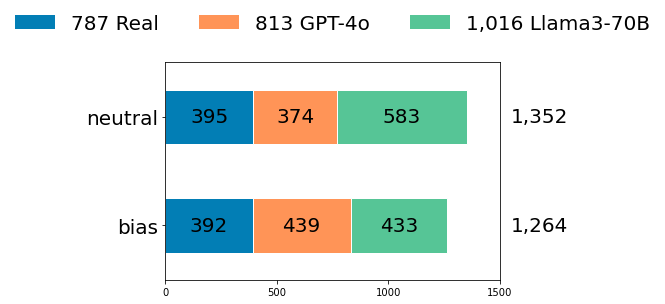

In [103]:
plot_neutral_vs_bias(df, None)

In [94]:
x = df[df['synthetic'] == False]
x = x[label_columns].apply(lambda x: any([ i for i in x]), axis=1).sum()
x

787

In [95]:
x = df[df['synthetic'] == False]
len(x[x['label_racial'] == True])

44

In [96]:
len(df[df['label_neutral'] == True])

1352

<Figure size 2160x1800 with 0 Axes>

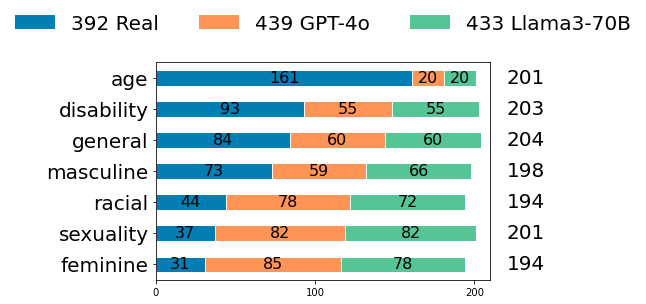

In [97]:
plot_by_category(df, None)

In [20]:
test_df = df[(df['synthetic']) & (df['type'] != 'gpt-4o') & (df['type'] == 'llama-3-70b')]
test_df

,id,label_age,analysis_age,label_disability,analysis_disability,label_feminine,analysis_feminine,label_general,analysis_general,label_masculine,...,label_sexuality,analysis_sexuality,verified,synthetic,text,metadata,model,type,country,source
0,Synthetic:meta-llama:Meta-Llama-3-70B-Instruct...,False,,False,,False,,False,,False,...,False,The sexuality rationale in this job posting is...,True,True,"Company: Barker, Pierce and Banks\nJob Title: ...","{""position"": ""standards specialist"", ""inferenc...",meta-llama:Meta-Llama-3-70B-Instruct,llama-3-70b,None,None
2,Synthetic:meta-llama:Meta-Llama-3-70B-Instruct...,False,,False,,False,,False,,False,...,False,,True,True,"Data and Technology Analyst at Hall, Johnson a...","{""position"": ""data and technology analyst"", ""i...",meta-llama:Meta-Llama-3-70B-Instruct,llama-3-70b,None,None
6,Synthetic:meta-llama:Meta-Llama-3-70B-Instruct...,False,,False,,False,,False,,False,...,False,,True,True,"Company: Chen, Ramos and Edwards\n\nJob Title:...","{""position"": ""Principal Release Engineer / Rel...",meta-llama:Meta-Llama-3-70B-Instruct,llama-3-70b,None,None
11,Synthetic:meta-llama:Meta-Llama-3-70B-Instruct...,False,,False,,False,,False,,False,...,False,,True,True,Job Title: Microsoft Consulting Services\nComp...,"{""position"": ""Microsoft Consulting Services"", ...",meta-llama:Meta-Llama-3-70B-Instruct,llama-3-70b,None,None
14,Synthetic:meta-llama:Meta-Llama-3-70B-Instruct...,False,,False,,False,"The job posting employs neutral language, avoi...",False,,False,...,False,,True,True,IT Security Analyst at Taylor-Newman\n\nCompan...,"{""position"": ""it security analyst"", ""inference...",meta-llama:Meta-Llama-3-70B-Instruct,llama-3-70b,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,Synthetic:meta-llama:Meta-Llama-3-70B-Instruct...,False,,False,,False,,False,,False,...,True,The sexuality rationale in this job posting is...,True,True,Job Title: Dietitian\nCompany: Smith-Acosta\n\...,"{""position"": ""dietitian"", ""inference_time"": 11...",meta-llama:Meta-Llama-3-70B-Instruct,llama-3-70b,None,None
577,Synthetic:meta-llama:Meta-Llama-3-70B-Instruct...,False,,False,,False,,False,,False,...,True,The job posting subtly discourages non-heteron...,True,True,"Company: Payne, Wilson and Beard\nRole: Examin...","{""position"": ""examiner"", ""inference_time"": 8.4...",meta-llama:Meta-Llama-3-70B-Instruct,llama-3-70b,None,None
580,Synthetic:meta-llama:Meta-Llama-3-70B-Instruct...,False,,False,,False,,False,,False,...,True,The job posting has a positive polarity toward...,True,True,"Company Background:\nElliott, Powell and Barbe...","{""position"": ""project manager"", ""inference_tim...",meta-llama:Meta-Llama-3-70B-Instruct,llama-3-70b,None,None
582,Synthetic:meta-llama:Meta-Llama-3-70B-Instruct...,False,,False,,False,,False,,False,...,True,The job posting subtly discourages non-heteron...,True,True,Job Title: Junior Accountant\nCompany: Nguyen ...,"{""position"": ""junior accountant"", ""inference_t...",meta-llama:Meta-Llama-3-70B-Instruct,llama-3-70b,None,None


In [21]:
filtered_df = df[(df['synthetic']) & ~(df['type'].isin(['gpt-4o', 'llama-3-70b']))]
filtered_df

,id,label_age,analysis_age,label_disability,analysis_disability,label_feminine,analysis_feminine,label_general,analysis_general,label_masculine,...,label_sexuality,analysis_sexuality,verified,synthetic,text,metadata,model,type,country,source


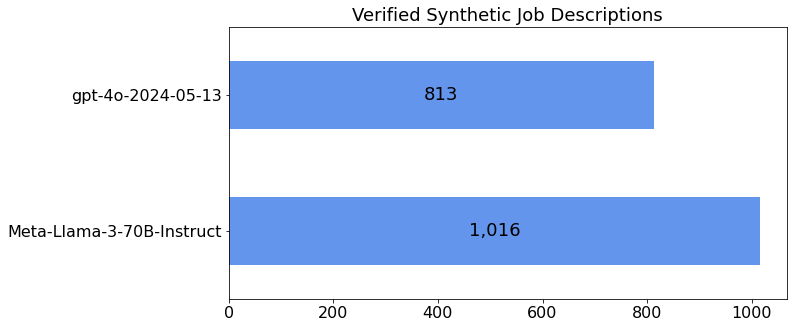

In [22]:
plot_by_models(df)